# Import

In [628]:
# settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [629]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from pyvis.network import Network
from IPython.display import HTML, display
from gensim.models.poincare import PoincareModel, PoincareRelations
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from src.load_datasets import load_dataset, load_rankings
from src.encoding import load_graph

In [630]:
# figure settings
sns.set()
sns.set(style='whitegrid', )
#sns.set_palette(palette="Set2")
sns.set_palette(palette="Paired")

# set seed
np.random.seed(7)

# Get data

In [631]:
def load_train_data(path: Union[Path, str], verbosity=1, subsample=None) -> (pd.DataFrame, pd.DataFrame):
    """
    Loads the Train data and splits into X_train and y_train

    :param path: str -- Path to the train data
    :param verbosity: int -- Level of verbosity
    :param subsample: int -- Number of subsamples to take

    :return: Tuple(pd.DataFrame, pd.DataFrame) -- X_train and y_train
    """

    if verbosity > 0:
        print("Loading train data ...")

    # Read csv file
    df = pd.read_csv(path, index_col=None)

    # Take subsample, if provided in the args
    if subsample is not None:
        print(f"Taking first {subsample} rows ...")
        df = df.iloc[:subsample]

    # Split into features and target
    X_train = df.drop("cv_score", axis=1)
    y_train = df["cv_score"]

    return X_train, y_train

In [632]:
dataset = load_dataset('../../data/raw/dataset.csv')
rankings = load_rankings('../../data/raw/rankings.csv')
X_train, y_train = load_train_data('../../data/raw/dataset_train.csv')

Loading data ...
Loading rankings ...
Loading train data ...


# Get graph

In [633]:
# get graph as networkx graph
G = load_graph("../../data/raw/graph.adjlist")
# show some information about the graph
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print("Graph information:")
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")

Graph information:
Number of nodes: 45
Number of edges: 44


### Visualize the graph

In [634]:
# create a Pyvis Network instance
nt = Network(heading="Hierarchical Structure Feature Encoder", notebook=True, cdn_resources='in_line')
# add nodes and edges to the Pyvis Network
nt.from_nx(G)
# show the Pyvis Network
html = nt.generate_html('encoder_graph.html')
display(HTML(html))

### Vector representations of those no de labels plotted on a 2d scatter graph
For a better visualization and interpretation I am adding the level feature as indicator if the nodes were actually in the same level of the hierarchy. The level feature is calculated by the degree of the node. The higher the degree the higher the level of the node. The level feature is then added as a color and size feature to the scatter plot. Another option would be to use the degree as a size feature and the level as a color feature.

In [635]:
def calculate_level(G):
    """
    Generates the feature hierarchical level for each node in the graph. Where the level defines the depth of the node in the graph hierarchy.

    :param G: The input graph.
    :type G: networkx.Graph

    :return: The graph with the hierarchical level.
    """
    levels = {}  # Dictionary to store hierarchical levels of nodes

    # Iterate over all nodes in the graph and calculate their hierarchical levels
    for node in G.nodes:
        if G.degree(node) == 0:
            levels[node] = 0
        else:
            max_level = 0
            for neighbor in G.neighbors(node):
                if neighbor in levels:
                    max_level = max(max_level, levels[neighbor] + 1)
            levels[node] = max_level

    # Add the hierarchical level as an attribute to each node in the graph
    nx.set_node_attributes(G, levels, "level")

    return G

In [636]:
# Get hierarchical level for each node
G = calculate_level(G)

In [637]:
# Print the hierarchical level for all nodes and make mapping dict
level_dict = {}
for node in G.nodes:
    print(f"Node: {node}, Level: {G.nodes[node]['level']}")
    level_dict[node] = G.nodes[node]['level']

Node: BE, Level: 0
Node: identifier, Level: 1
Node: BUCV10RGLMME, Level: 0
Node: bucvglmm, Level: 1
Node: BUCV10TE, Level: 0
Node: bucvte, Level: 1
Node: BUCV2RGLMME, Level: 2
Node: BUCV2TE, Level: 2
Node: BUCV5RGLMME, Level: 2
Node: BUCV5TE, Level: 2
Node: CBE, Level: 0
Node: supervised, Level: 1
Node: CE, Level: 0
Node: unsupervised, Level: 2
Node: CV10RGLMME, Level: 0
Node: cvglmm, Level: 1
Node: CV10TE, Level: 0
Node: cvte, Level: 1
Node: CV2RGLMME, Level: 2
Node: CV2TE, Level: 2
Node: CV5RGLMME, Level: 2
Node: CV5TE, Level: 2
Node: DE, Level: 3
Node: DTEM10, Level: 0
Node: dte, Level: 2
Node: DTEM2, Level: 3
Node: DTEM5, Level: 3
Node: ME01E, Level: 0
Node: mee, Level: 2
Node: ME10E, Level: 3
Node: ME1E, Level: 3
Node: MHE, Level: 3
Node: OE, Level: 2
Node: OHE, Level: 2
Node: PBTE0001, Level: 0
Node: pbte, Level: 2
Node: PBTE001, Level: 3
Node: PBTE01, Level: 3
Node: RGLMME, Level: 0
Node: glmm, Level: 2
Node: SE, Level: 3
Node: TE, Level: 0
Node: te, Level: 2
Node: WOEE, Level: 

In [638]:
# Print the degree for all nodes and make mapping dict
degree_dict = {}
for node in G.nodes:
    print(f"Node: {node}, Degree: {G.degree(node)}")
    degree_dict[node] = G.degree(node)

Node: BE, Degree: 1
Node: identifier, Degree: 4
Node: BUCV10RGLMME, Degree: 1
Node: bucvglmm, Degree: 4
Node: BUCV10TE, Degree: 1
Node: bucvte, Degree: 4
Node: BUCV2RGLMME, Degree: 1
Node: BUCV2TE, Degree: 1
Node: BUCV5RGLMME, Degree: 1
Node: BUCV5TE, Degree: 1
Node: CBE, Degree: 1
Node: supervised, Degree: 8
Node: CE, Degree: 1
Node: unsupervised, Degree: 6
Node: CV10RGLMME, Degree: 1
Node: cvglmm, Degree: 4
Node: CV10TE, Degree: 1
Node: cvte, Degree: 4
Node: CV2RGLMME, Degree: 1
Node: CV2TE, Degree: 1
Node: CV5RGLMME, Degree: 1
Node: CV5TE, Degree: 1
Node: DE, Degree: 1
Node: DTEM10, Degree: 1
Node: dte, Degree: 4
Node: DTEM2, Degree: 1
Node: DTEM5, Degree: 1
Node: ME01E, Degree: 1
Node: mee, Degree: 4
Node: ME10E, Degree: 1
Node: ME1E, Degree: 1
Node: MHE, Degree: 1
Node: OE, Degree: 1
Node: OHE, Degree: 1
Node: PBTE0001, Degree: 1
Node: pbte, Degree: 4
Node: PBTE001, Degree: 1
Node: PBTE01, Degree: 1
Node: RGLMME, Degree: 1
Node: glmm, Degree: 4
Node: SE, Degree: 1
Node: TE, Degree

In [639]:
# Get the position of each node in the graph
pos = nx.spring_layout(G, k=0.5, iterations=50)

In [640]:
# Extract x and y coordinates and combine with the level attribute
graph_df = pd.DataFrame.from_dict(pos, orient='index', columns=['x', 'y'])
graph_df['level'] = nx.get_node_attributes(G, 'level')
graph_df['degree'] = pd.Series(degree_dict)

In [641]:
graph_df

,x,y,level,degree
BE,-0.639424,0.616036,0,1
identifier,-0.229179,0.352920,1,4
BUCV10RGLMME,0.308321,-0.587731,0,1
bucvglmm,-0.190442,-0.771191,1,4
BUCV10TE,-0.408692,0.711284,0,1
bucvte,-0.029276,0.496480,1,4
BUCV2RGLMME,-0.425016,-1.000000,2,1
BUCV2TE,-0.302639,0.868658,2,1
BUCV5RGLMME,-0.529198,-0.807328,2,1
BUCV5TE,0.394581,-0.035033,2,1


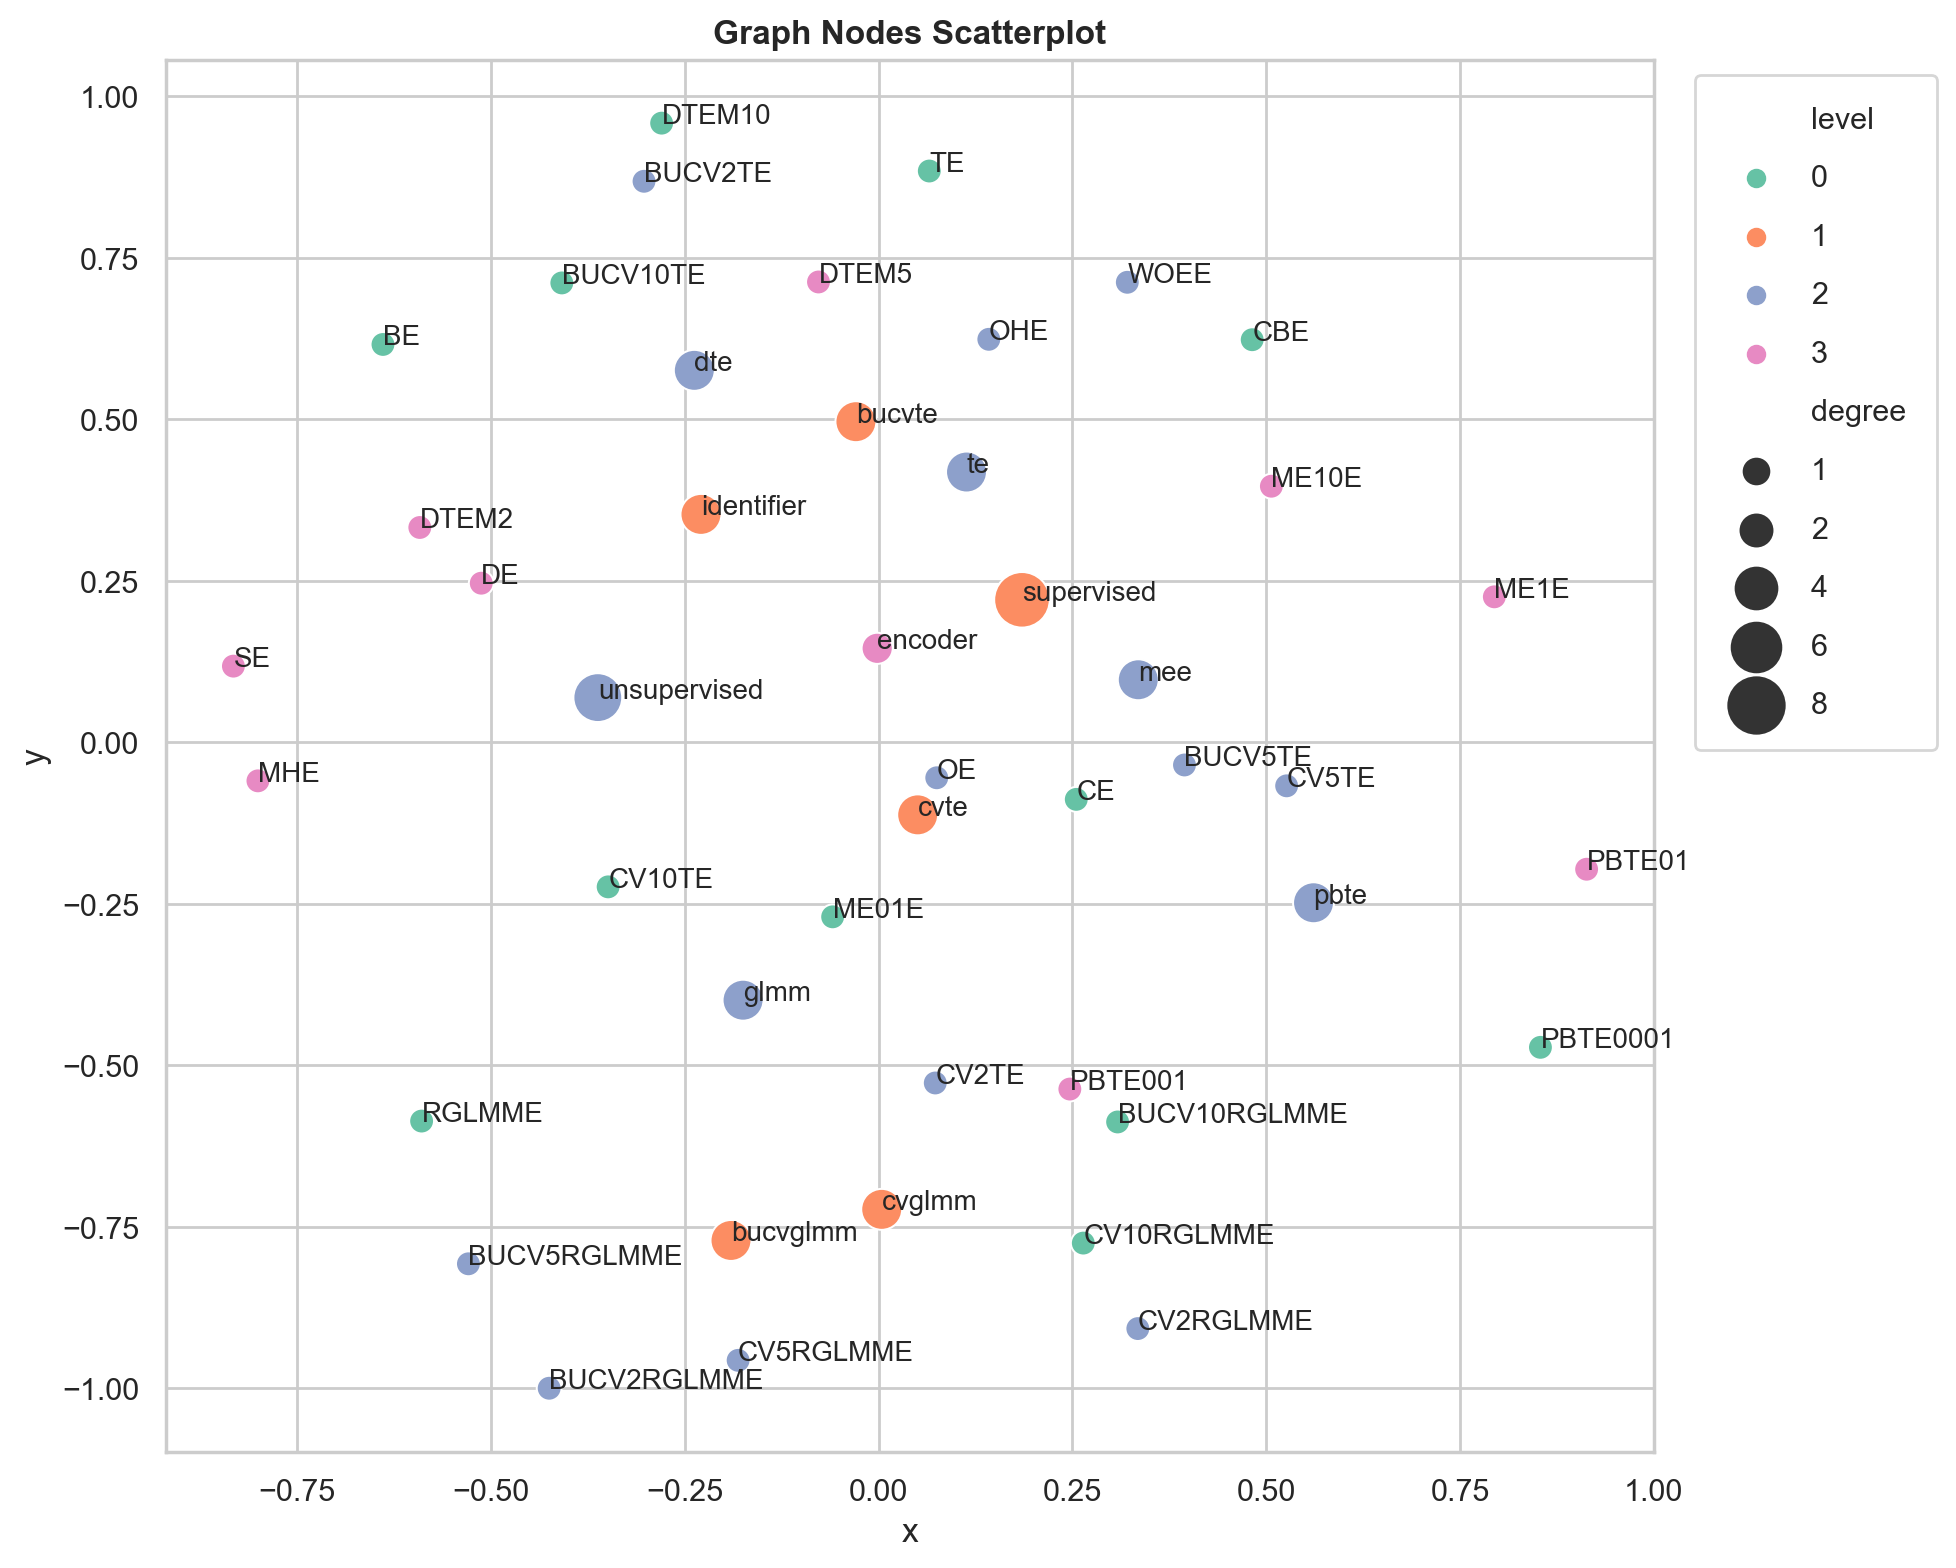

In [642]:
# Make scatter plot of the nodes
plt.figure(figsize=(10, 8))
sns.scatterplot(data=graph_df, x='x', y='y', size='degree', sizes=(80, 400), hue='level', palette='Set2')
# Add node labels as annotations to the plot
for node, (x, y) in pos.items():
    plt.text(x, y, node, fontsize=10)
# Add title to the plot
plt.title('Graph Nodes Scatterplot', fontweight='bold')
# Add legend
plt.legend(labelspacing=1, borderpad=1, loc='upper right', bbox_to_anchor=(1.2, 1))
# Show plot
plt.tight_layout()
plt.show()

# Poincarè embedding
We want to encode the feature encoder using the [Poincarè Embedding](https://radimrehurek.com/gensim/models/poincare.html). By doing this we encode the hierarchical structure of the feature encoder and preserve it. The graph with the hierarchical structure is given in [data/raw](../../data/raw), the library networkx is used to load the graph.

Hierarchies are often trees where the number of nodes increases exponentially by the level, so we want a space that increases exponentially as we deviate from the “origin” of the space. The Poincaré ball follows this property, so we can define our vectors on this space. We define a loss function that gives a good score for clustering vectors in the same hierarchy and spreading out vectors in different hierarchies. Finally, we can find vectors to minimize our loss function using Riemann gradient descent and get a good numerical representation of the words being the name of the encoders.

The method is described in [Maximilian Nickel, Douwe Kiela - “Poincaré Embeddings for Learning Hierarchical Representations”](https://arxiv.org/abs/1705.08039)

## Run Embedding

In [643]:
%%time
# Extract all relations form the graph
relations = []
for edge in G.edges():
    relations.append((edge[0], edge[1]))

CPU times: total: 0 ns
Wall time: 0 ns


In [644]:
%%time
# Embed the graph
model = PoincareModel(relations, seed=7)
# Train the model
model.train(epochs=5000, print_every=500)

CPU times: total: 7.55 s
Wall time: 22.5 s


In [645]:
# Get the embeddings (vector representation) of the nodes hierarchy structure
embeddings = model.kv.vectors
# Map embeddings (vector representation) to node names
embeddings_dict = {}
for node in G.nodes:
    embeddings_dict[node] = model.kv[node]

In [646]:
# Transform embeddings (vector representation) to a dataframe
embeddings_df = pd.DataFrame(embeddings)
# Add node names as a column to the dataframe
embeddings_df['node'] = embeddings_dict.keys()
embeddings_df = embeddings_df.set_index('node')
# Rename columns to dimension_1, dimension_2, ...
embeddings_df.columns = [f'dimension_{i}' for i in range(1, embeddings_df.shape[1] + 1)]
embeddings_df

,dimension_1,dimension_2,dimension_3,dimension_4,dimension_5,dimension_6,dimension_7,dimension_8,dimension_9,dimension_10,...,dimension_41,dimension_42,dimension_43,dimension_44,dimension_45,dimension_46,dimension_47,dimension_48,dimension_49,dimension_50
node,,,,,,,,,,,,,,,,,,,,,
BE,0.017022,0.093297,0.177198,-0.010911,-0.021327,-0.107233,-0.092924,0.065719,0.127601,0.009352,...,-0.028792,0.106975,-0.029600,0.259296,-0.195313,-0.103896,-0.003615,0.049727,-0.029597,0.291859
identifier,0.016701,0.090865,0.172922,-0.010525,-0.020648,-0.104905,-0.090487,0.063945,0.124560,0.008906,...,-0.028138,0.104497,-0.028731,0.252891,-0.190763,-0.101384,-0.003575,0.048526,-0.028703,0.284742
BUCV10RGLMME,0.016611,0.090991,0.172834,-0.010636,-0.020788,-0.104616,-0.090638,0.064097,0.124469,0.009094,...,-0.028095,0.104358,-0.028858,0.252905,-0.190527,-0.101334,-0.003536,0.048500,-0.028853,0.284677
bucvglmm,0.016621,0.090839,0.172649,-0.010588,-0.020717,-0.104581,-0.090478,0.063970,0.124345,0.009022,...,-0.028075,0.104275,-0.028782,0.252589,-0.190369,-0.101225,-0.003544,0.048448,-0.028770,0.284348
BUCV10TE,0.020424,0.061432,0.144713,0.001309,-0.003877,-0.108665,-0.059773,0.037434,0.106744,-0.010256,...,-0.026648,0.095605,-0.011685,0.199177,-0.172830,-0.084376,-0.006737,0.041177,-0.009392,0.231476
bucvte,0.232103,-0.063685,-0.131307,-0.117467,-0.124104,0.120472,0.057572,0.317808,0.091411,0.087980,...,-0.021960,-0.084179,-0.047778,-0.075785,0.168503,0.062065,-0.041641,-0.218202,-0.053104,0.114107
BUCV2RGLMME,0.208804,-0.056545,-0.119364,-0.106077,-0.112729,0.109937,0.051967,0.287820,0.082327,0.080870,...,-0.019022,-0.076176,-0.041612,-0.067432,0.153162,0.054913,-0.036197,-0.196433,-0.048862,0.102118
BUCV2TE,0.207658,-0.056234,-0.118692,-0.105492,-0.112102,0.109325,0.051692,0.286224,0.081872,0.080424,...,-0.018924,-0.075758,-0.041394,-0.067053,0.152318,0.054616,-0.035998,-0.195351,-0.048578,0.101576
BUCV5RGLMME,0.206398,-0.055730,-0.118251,-0.104931,-0.111655,0.109012,0.051471,0.284901,0.081379,0.080356,...,-0.018628,-0.075384,-0.040838,-0.066461,0.151757,0.054097,-0.035460,-0.194176,-0.048526,0.100837


## Build Encoder function

In [647]:
def poincare_encoding(path_to_graph, data=None, column_to_encode=None, encode_dim=None, epochs=10000, seed=7, explode_dim=False):
    """
    Generates the Poincarè embedding for the given graph and encodes the given column of the given data with it. The encoding can be done in different formats. The function can also be used to just generate the embedding for the given graph. The graph has to be given as an edge list.

    :param path_to_graph: Path to the graph.
    :type path_to_graph: str
    :param data: Data to encode.
    :type data: pandas.DataFrame
    :param column_to_encode: Column to encode.
    :type column_to_encode: str
    :param encode_dim: Dimension of the embedding.
    :type encode_dim: int
    :param epochs: Number of epochs to train the model.
    :type epochs: int
    :param seed: Seed for the random number generator.
    :type seed: int
    :param explode_dim: If True, the embedding is exploded into multiple columns.
    :type explode_dim: bool

    :return: The encoded data.
    :rtype: pandas.DataFrame
    """
    # load Graph
    G = load_graph(path_to_graph)
    # Extract all relations form the graph
    relations = []
    for edge in G.edges():
        relations.append((edge[0], edge[1]))
    # Embed the graph
    if encode_dim is None:
        model = PoincareModel(relations, seed=seed)
    else:
        model = PoincareModel(relations, seed=seed, size=encode_dim)
    # Train the model
    model.train(epochs=epochs, print_every=500)
    # Get the embeddings and map them to the node names
    emb_df = (
        pd.DataFrame(
            [model.kv.get_vector(str(n)) for n in G.nodes()],
            index = G.nodes
        )
    )
    if data is None or column_to_encode is None:
        # Rename columns to dimension_1, dimension_2, ...
        emb_df.columns = [f'dimension_{col}' for col in emb_df.columns]
        return emb_df
    else:
        # Explode embeddings dimensions to multiple columns
        if explode_dim:
            # Rename columns to enc_dim1, enc_dim2, ...
            emb_df.columns = [f'enc_dim_{col}' for col in emb_df.columns]
            # Merge the embeddings with the data
            encoded_data_df = data.merge(emb_df, left_on=column_to_encode, right_index=True)
            # Drop the node column
            encoded_data_df.drop(column_to_encode, axis=1, inplace=True)
        else:
            encoded_data_df = data.copy()
            encoded_data_df[column_to_encode] = encoded_data_df[column_to_encode].apply(lambda x: model.kv.get_vector(str(x)))
        return encoded_data_df

In [648]:
%%time
df = poincare_encoding("../../data/raw/graph.adjlist", data=X_train, column_to_encode='encoder', epochs=5, explode_dim=False)
df

CPU times: total: 46.9 ms
Wall time: 141 ms


,dataset,model,tuning,scoring,encoder
0,1169,KNC,model,ACC,"[0.06405934526557484, -0.022053919652529747, -..."
1,1169,KNC,model,ACC,"[0.018441537574978253, -0.004763721242288602, ..."
2,1169,KNC,model,ACC,"[-0.019170620682241606, -0.037247715943548025,..."
3,1169,KNC,model,ACC,"[0.012186276730228662, 0.014085839864860356, 0..."
4,1169,KNC,model,ACC,"[0.00010255777527655701, 0.03225381827328732, ..."
...,...,...,...,...,...
36049,470,LR,no,AUC,"[-0.009002363784013374, -0.008787681490916393,..."
36050,470,LR,no,AUC,"[0.025352627855745262, -0.003910202635099624, ..."
36051,470,LR,no,AUC,"[0.011247815773826088, 0.009417989154005477, 0..."
36052,470,LR,no,AUC,"[-0.026158835141001997, 0.007896632361156546, ..."


## Visualization & Evaluation

In [729]:
# Plot the embedding in an 2D scatter plot with a widget to select the level to plot
def plot_embeddigs(data, levels, subtitle='', dim=2):
    # filter df
    data_filtered = data[data['level'].isin(levels)]
    # plot
    fig = plt.figure(figsize=(10, 7))
    if dim == 2:
        sns.scatterplot(data=data_filtered, x='dimension_1', y='dimension_2', size='degree', sizes=(80, 400), hue='level', palette='Set2')
        # Add node labels as annotations to the plot
        for node, (x, y, level, degree) in data_filtered.iterrows():
            plt.text(x, y, node, fontsize=10)
    elif dim == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(data_filtered['dimension_1'], data_filtered['dimension_2'], data_filtered['dimension_3'], c=data_filtered['level'], cmap='Set2', s=data_filtered['degree'])
        # Add node labels as annotations to the plot
        for node, (x, y, z, level, degree) in data_filtered.iterrows():
            ax.text(x, y, z, node, fontsize=10)
    # Add title to the plot
    plt.title("Poincaré Embedding" + f"{subtitle}", fontweight='bold')
    # Add legend
    plt.legend(labelspacing=1, borderpad=1, loc='upper right', bbox_to_anchor=(1.2, 1, ))
    # Name axes
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    # Show plot
    plt.tight_layout()
    plt.show()

### Dimensionality reduction t-SNE

In [650]:
# Perform dimensionality reduction using t-SNE (2 dimensions)
tsne = TSNE(n_components=2, random_state=7)
embeddings_2d_tsne = tsne.fit_transform(embeddings_df.values)
embeddings_2d_df_tsne = pd.DataFrame(embeddings_2d_tsne, index=embeddings_df.index, columns=['dimension_1', 'dimension_2'])

In [651]:
# Add hierarchical level and degree as a column to the dataframe where node names are the index
embeddings_2d_df_tsne['level'] = nx.get_node_attributes(G, 'level').values()
embeddings_2d_df_tsne['degree'] = pd.Series(degree_dict)
embeddings_2d_df_tsne

,dimension_1,dimension_2,level,degree
node,,,,
BE,-0.035713,-7.154251,0,1
identifier,-0.253479,-7.089592,1,4
BUCV10RGLMME,-0.266439,-7.085462,0,1
bucvglmm,-0.274370,-7.081058,1,4
BUCV10TE,-0.036349,-6.652682,0,1
bucvte,0.445171,-2.680162,1,4
BUCV2RGLMME,0.421230,-2.801278,2,1
BUCV2TE,0.420141,-2.808120,2,1
BUCV5RGLMME,0.417889,-2.816706,2,1


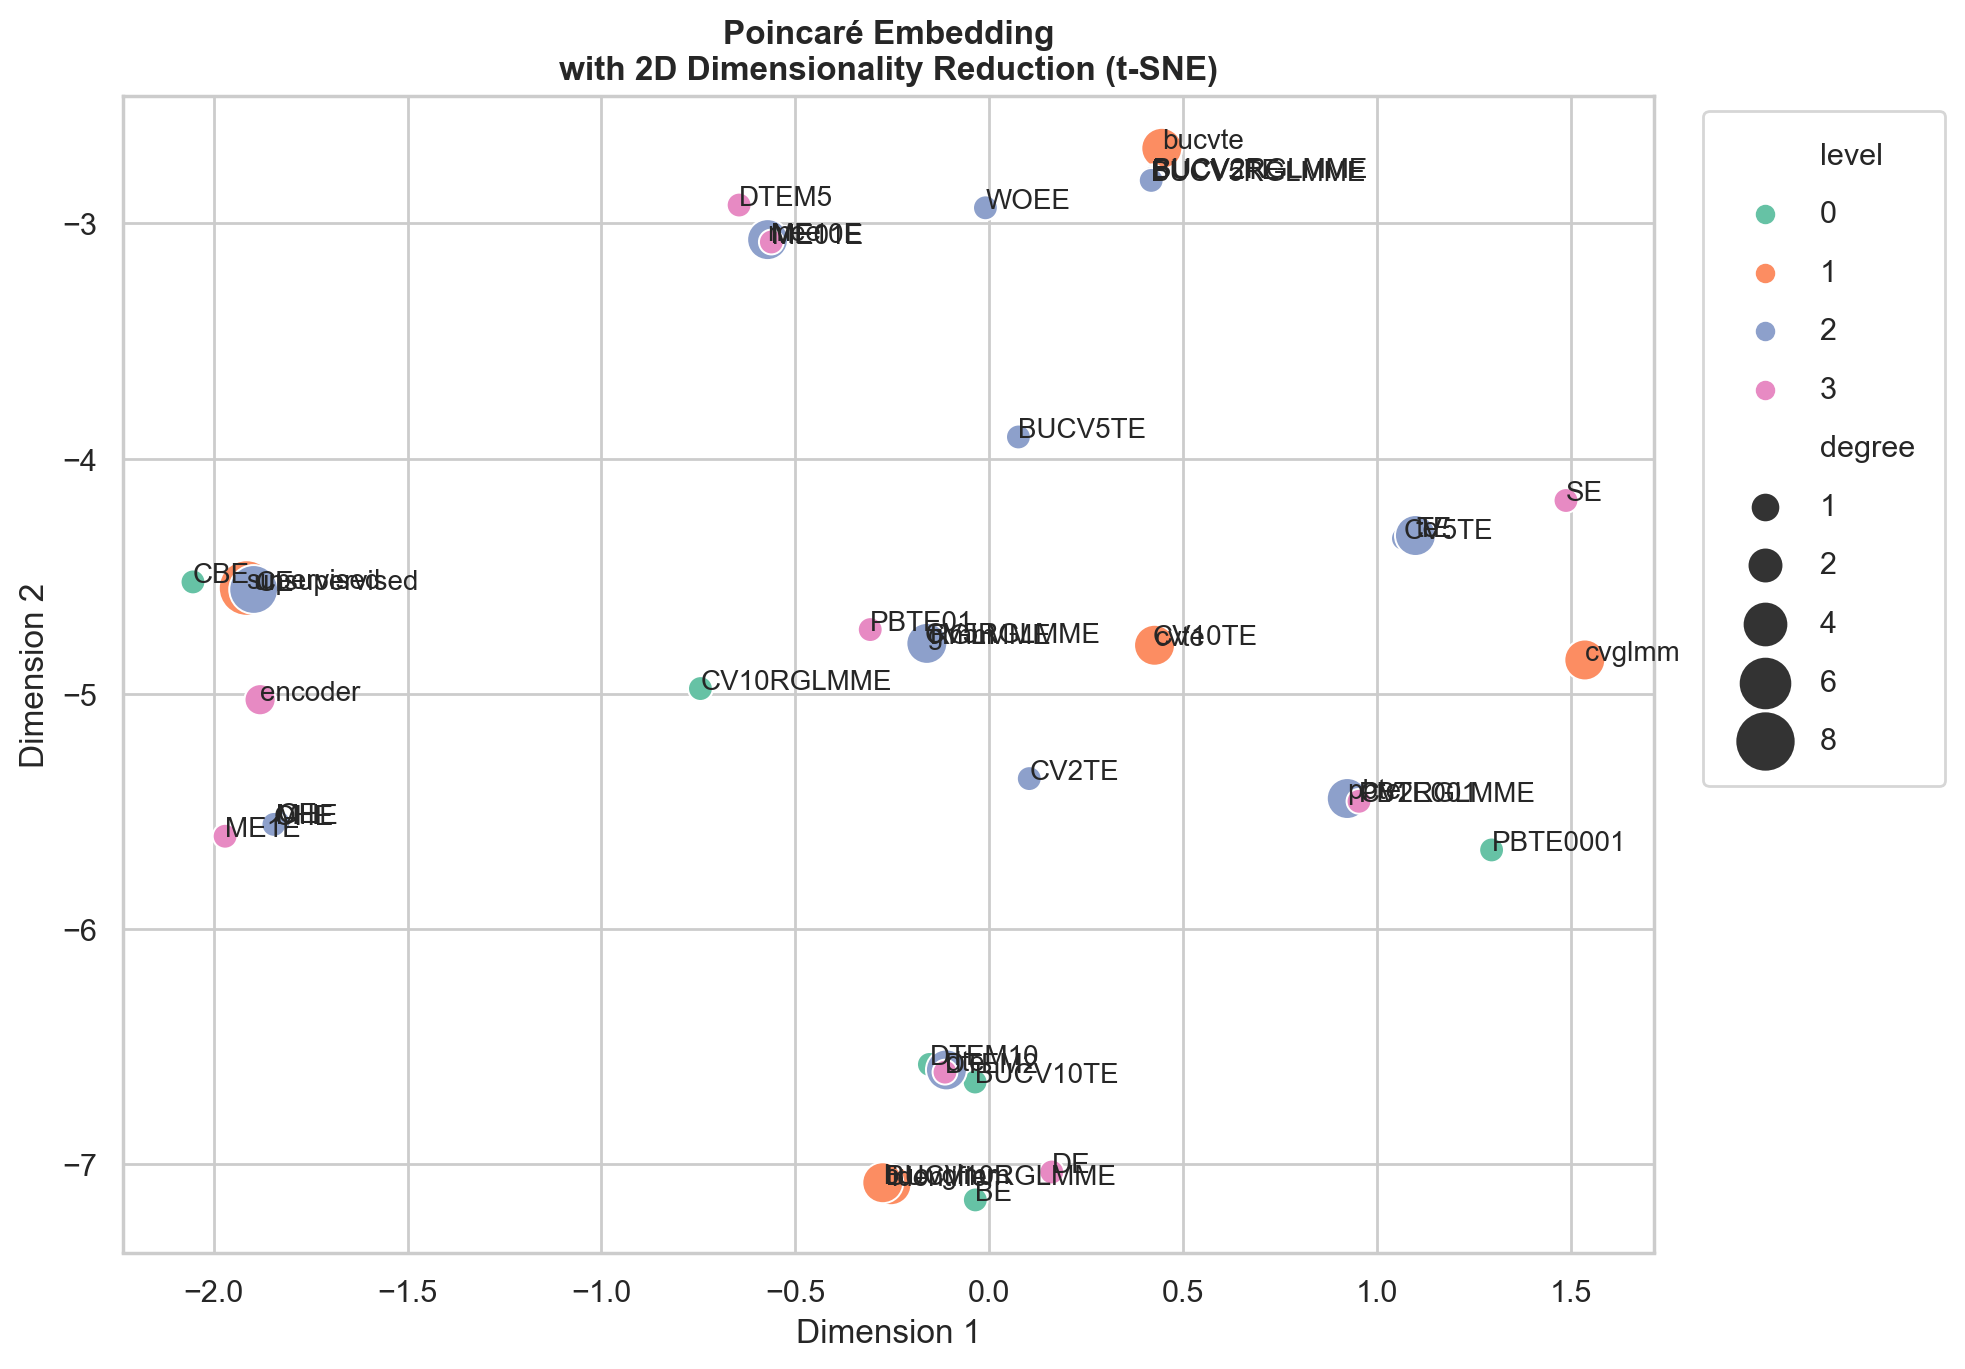

In [730]:
plot_embeddigs(levels=[0, 1, 2, 3, 4], data=embeddings_2d_df_tsne, subtitle='\n'+'with 2D Dimensionality Reduction (t-SNE)')

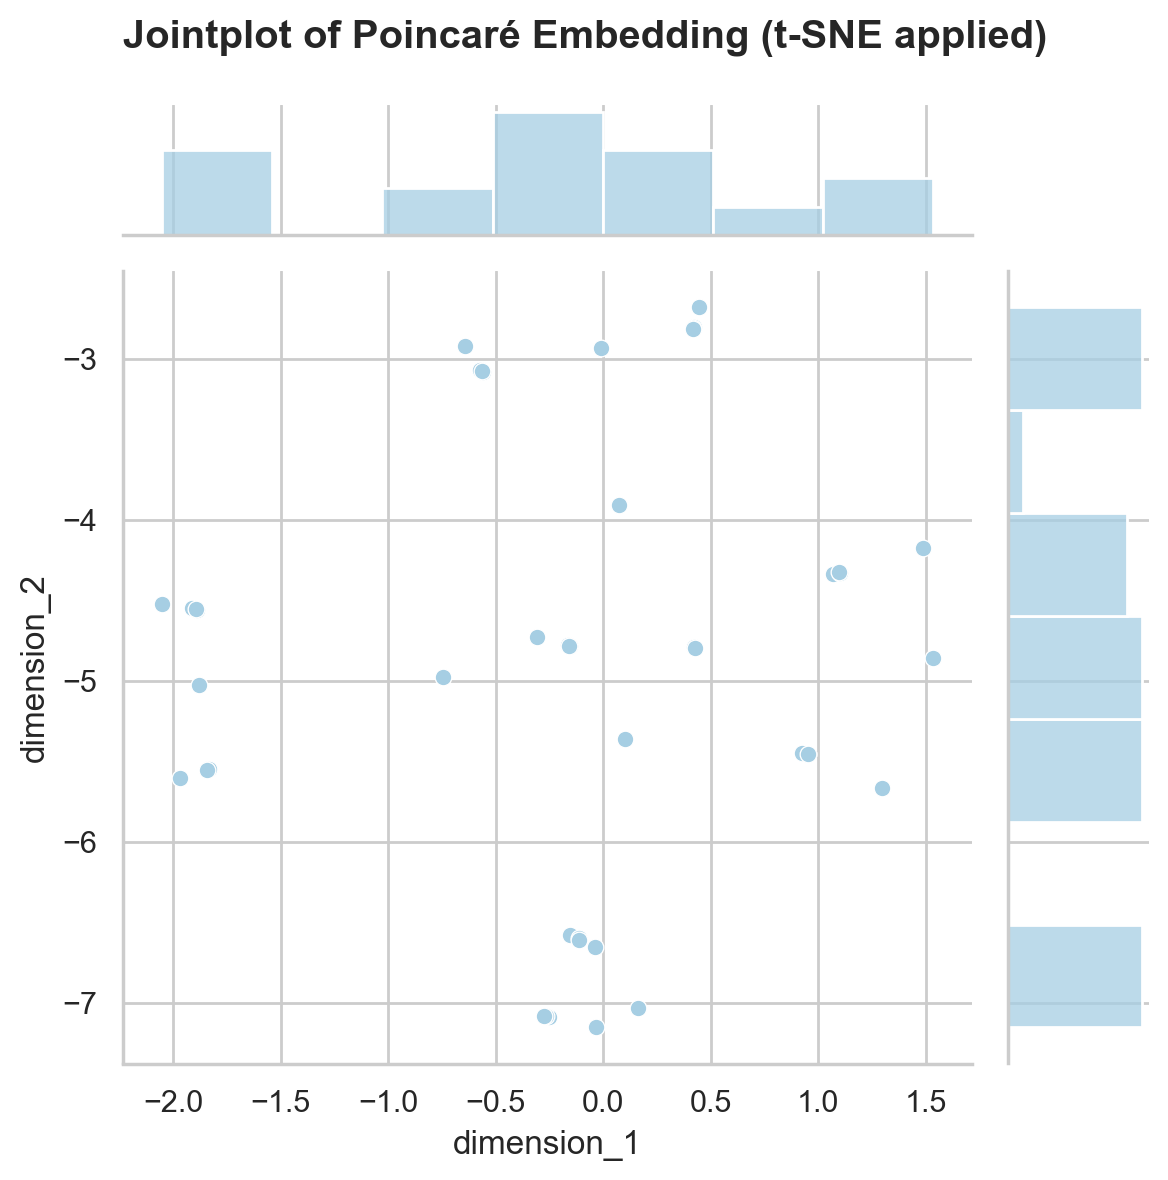

In [690]:
# make jointplot
sns.jointplot(data=embeddings_2d_df_tsne, x='dimension_1', y='dimension_2')
plt.suptitle("Jointplot of Poincaré Embedding (t-SNE applied)", fontweight='bold')
plt.tight_layout()
plt.show()

Findings:
* The embedding is not very good, but it is possible to see that the nodes are clustered by their hierarchical level.

### Dimensionality reduction PCA

In [653]:
# Perform dimensionality reduction using PCA
pca = PCA(n_components=2, random_state=7)
embeddings_2d_pca = pca.fit_transform(embeddings_df.values)
embeddings_2d_df_pca = pd.DataFrame(embeddings_2d_pca, index=embeddings_df.index, columns=['dimension_1', 'dimension_2'])

In [654]:
# Add hierarchical level and degree as a column to the dataframe where node names are the index
embeddings_2d_df_pca['level'] = nx.get_node_attributes(G, 'level').values()
embeddings_2d_df_pca['degree'] = pd.Series(degree_dict)
embeddings_2d_df_pca

,dimension_1,dimension_2,level,degree
node,,,,
BE,0.894882,-0.088386,0,1
identifier,0.871478,-0.086264,1,4
BUCV10RGLMME,0.871263,-0.086033,0,1
bucvglmm,0.870182,-0.085990,1,4
BUCV10TE,0.698040,-0.089902,0,1
bucvte,-0.195911,0.673013,1,4
BUCV2RGLMME,-0.183978,0.611652,2,1
BUCV2TE,-0.183282,0.608311,2,1
BUCV5RGLMME,-0.182811,0.605897,2,1


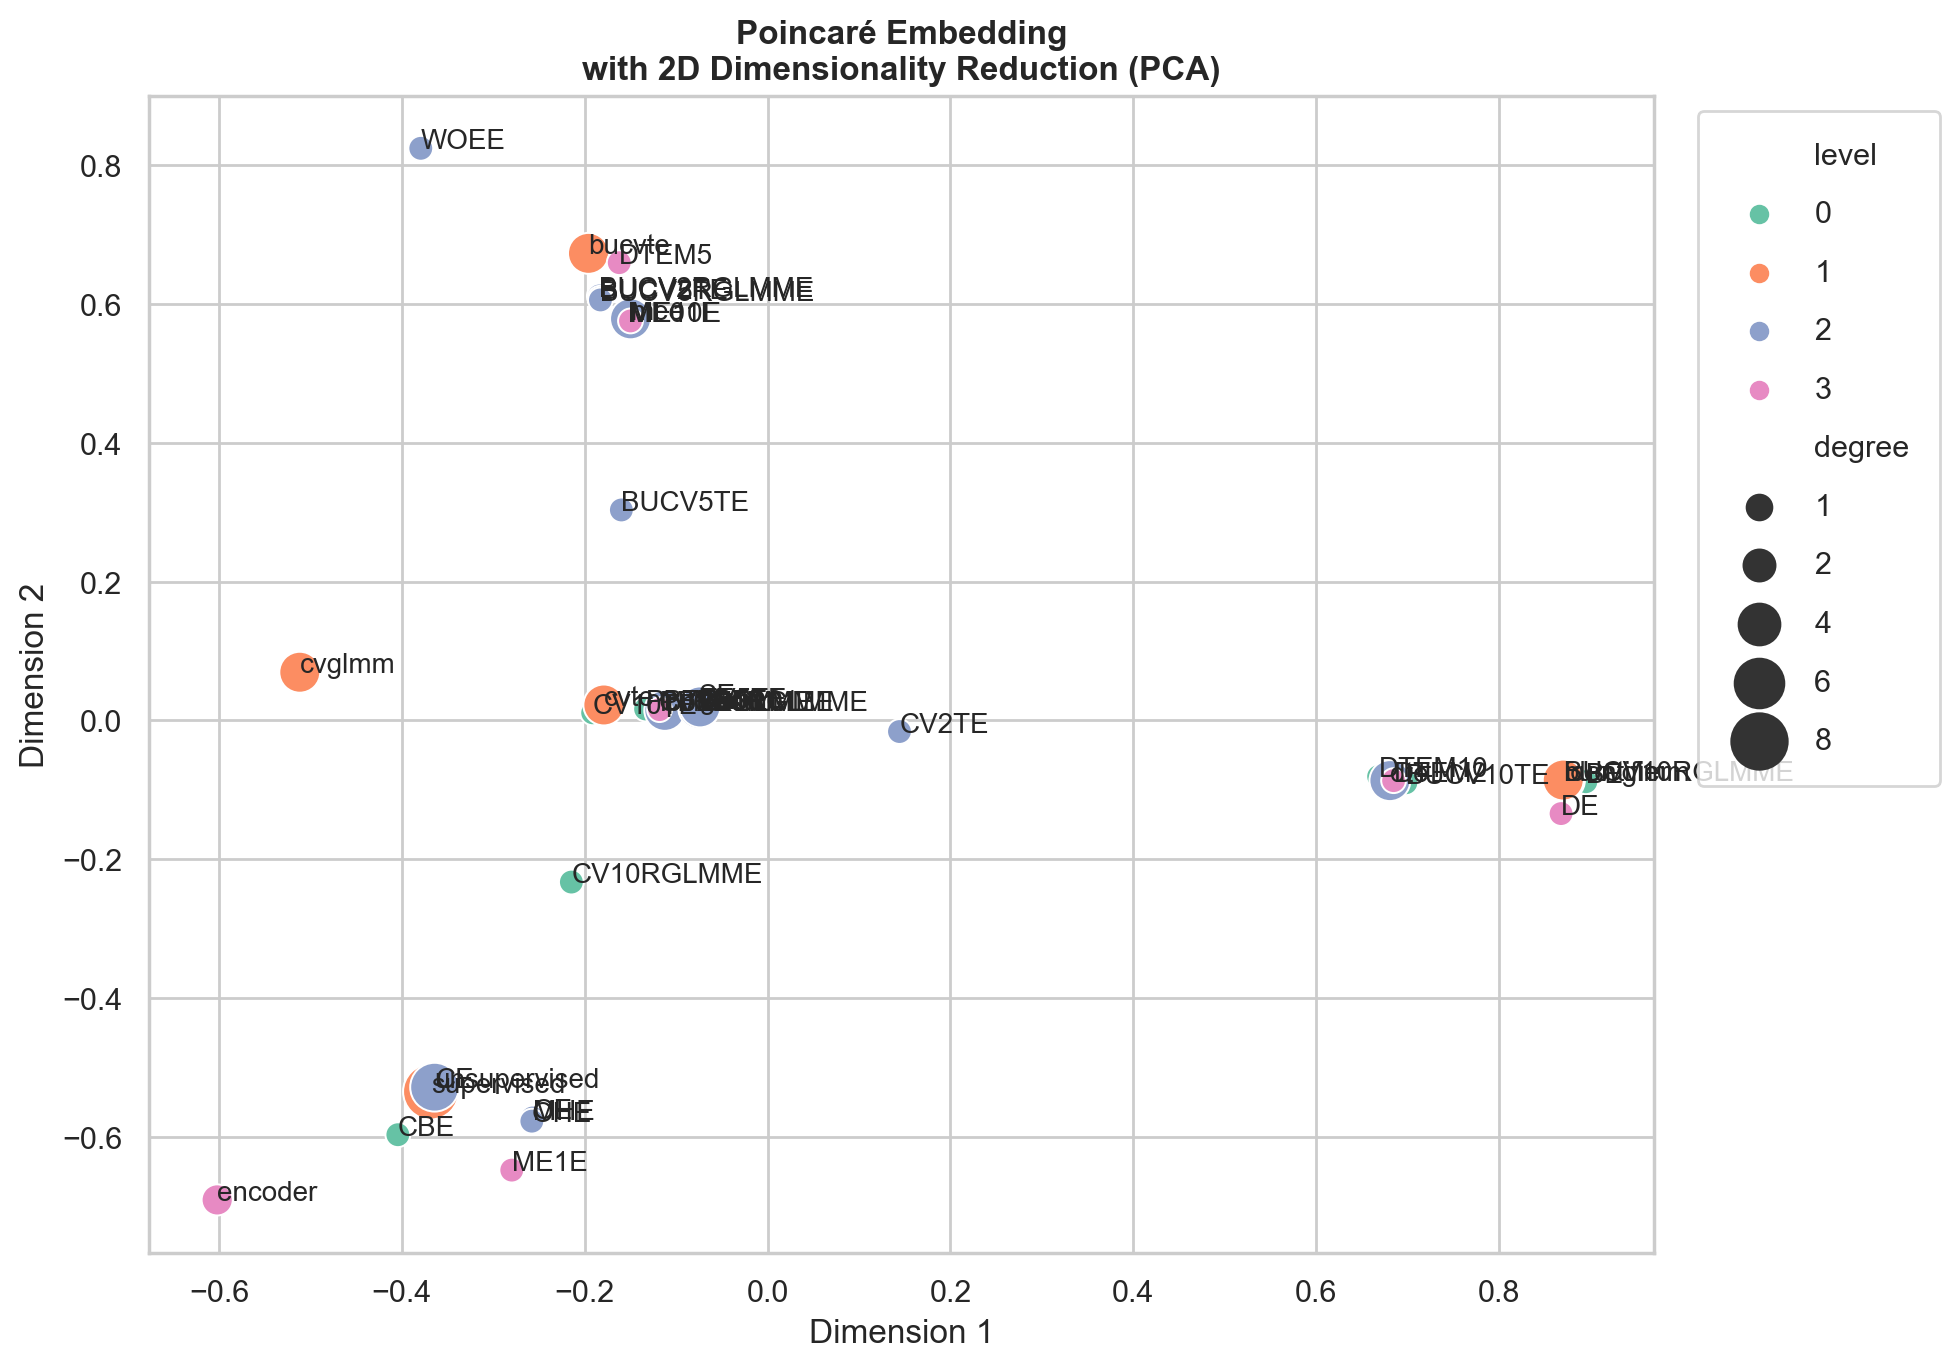

In [731]:
plot_embeddigs(levels=[0, 1, 2, 3, 4], data=embeddings_2d_df_pca, subtitle='\n'+'with 2D Dimensionality Reduction (PCA)')

Findings:
* The nodes are obviously somehow clustered, but it is not clear if this directly relates to the level oder degree of the node.

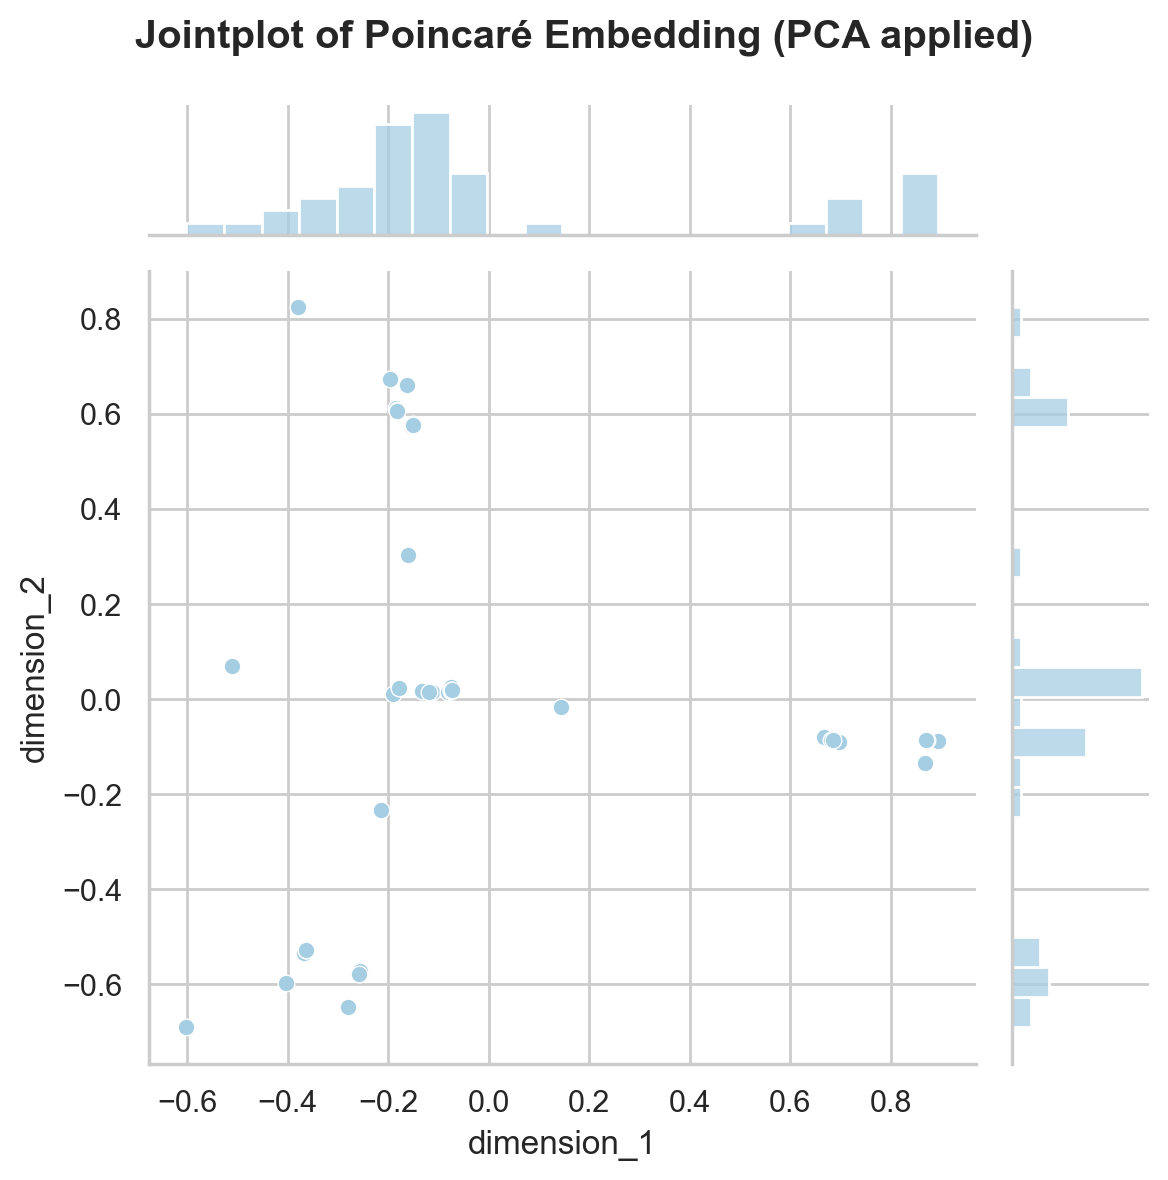

In [691]:
# make jointplot
sns.jointplot(data=embeddings_2d_df_pca, x='dimension_1', y='dimension_2')
plt.suptitle("Jointplot of Poincaré Embedding (PCA applied)", fontweight='bold')
plt.tight_layout()
plt.show()

# Experimental: 3D plots

## PCA

,dimension_1,dimension_2,dimension_3,level,degree
node,,,,,
BE,0.894882,-0.088386,-0.130466,0,1
identifier,0.871478,-0.086264,-0.123965,1,4
BUCV10RGLMME,0.871263,-0.086033,-0.124640,0,1
bucvglmm,0.870182,-0.085990,-0.124143,1,4
BUCV10TE,0.698040,-0.089902,-0.019186,0,1
bucvte,-0.195911,0.673013,-0.390860,1,4
BUCV2RGLMME,-0.183978,0.611652,-0.344230,2,1
BUCV2TE,-0.183282,0.608311,-0.341751,2,1
BUCV5RGLMME,-0.182811,0.605897,-0.339726,2,1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


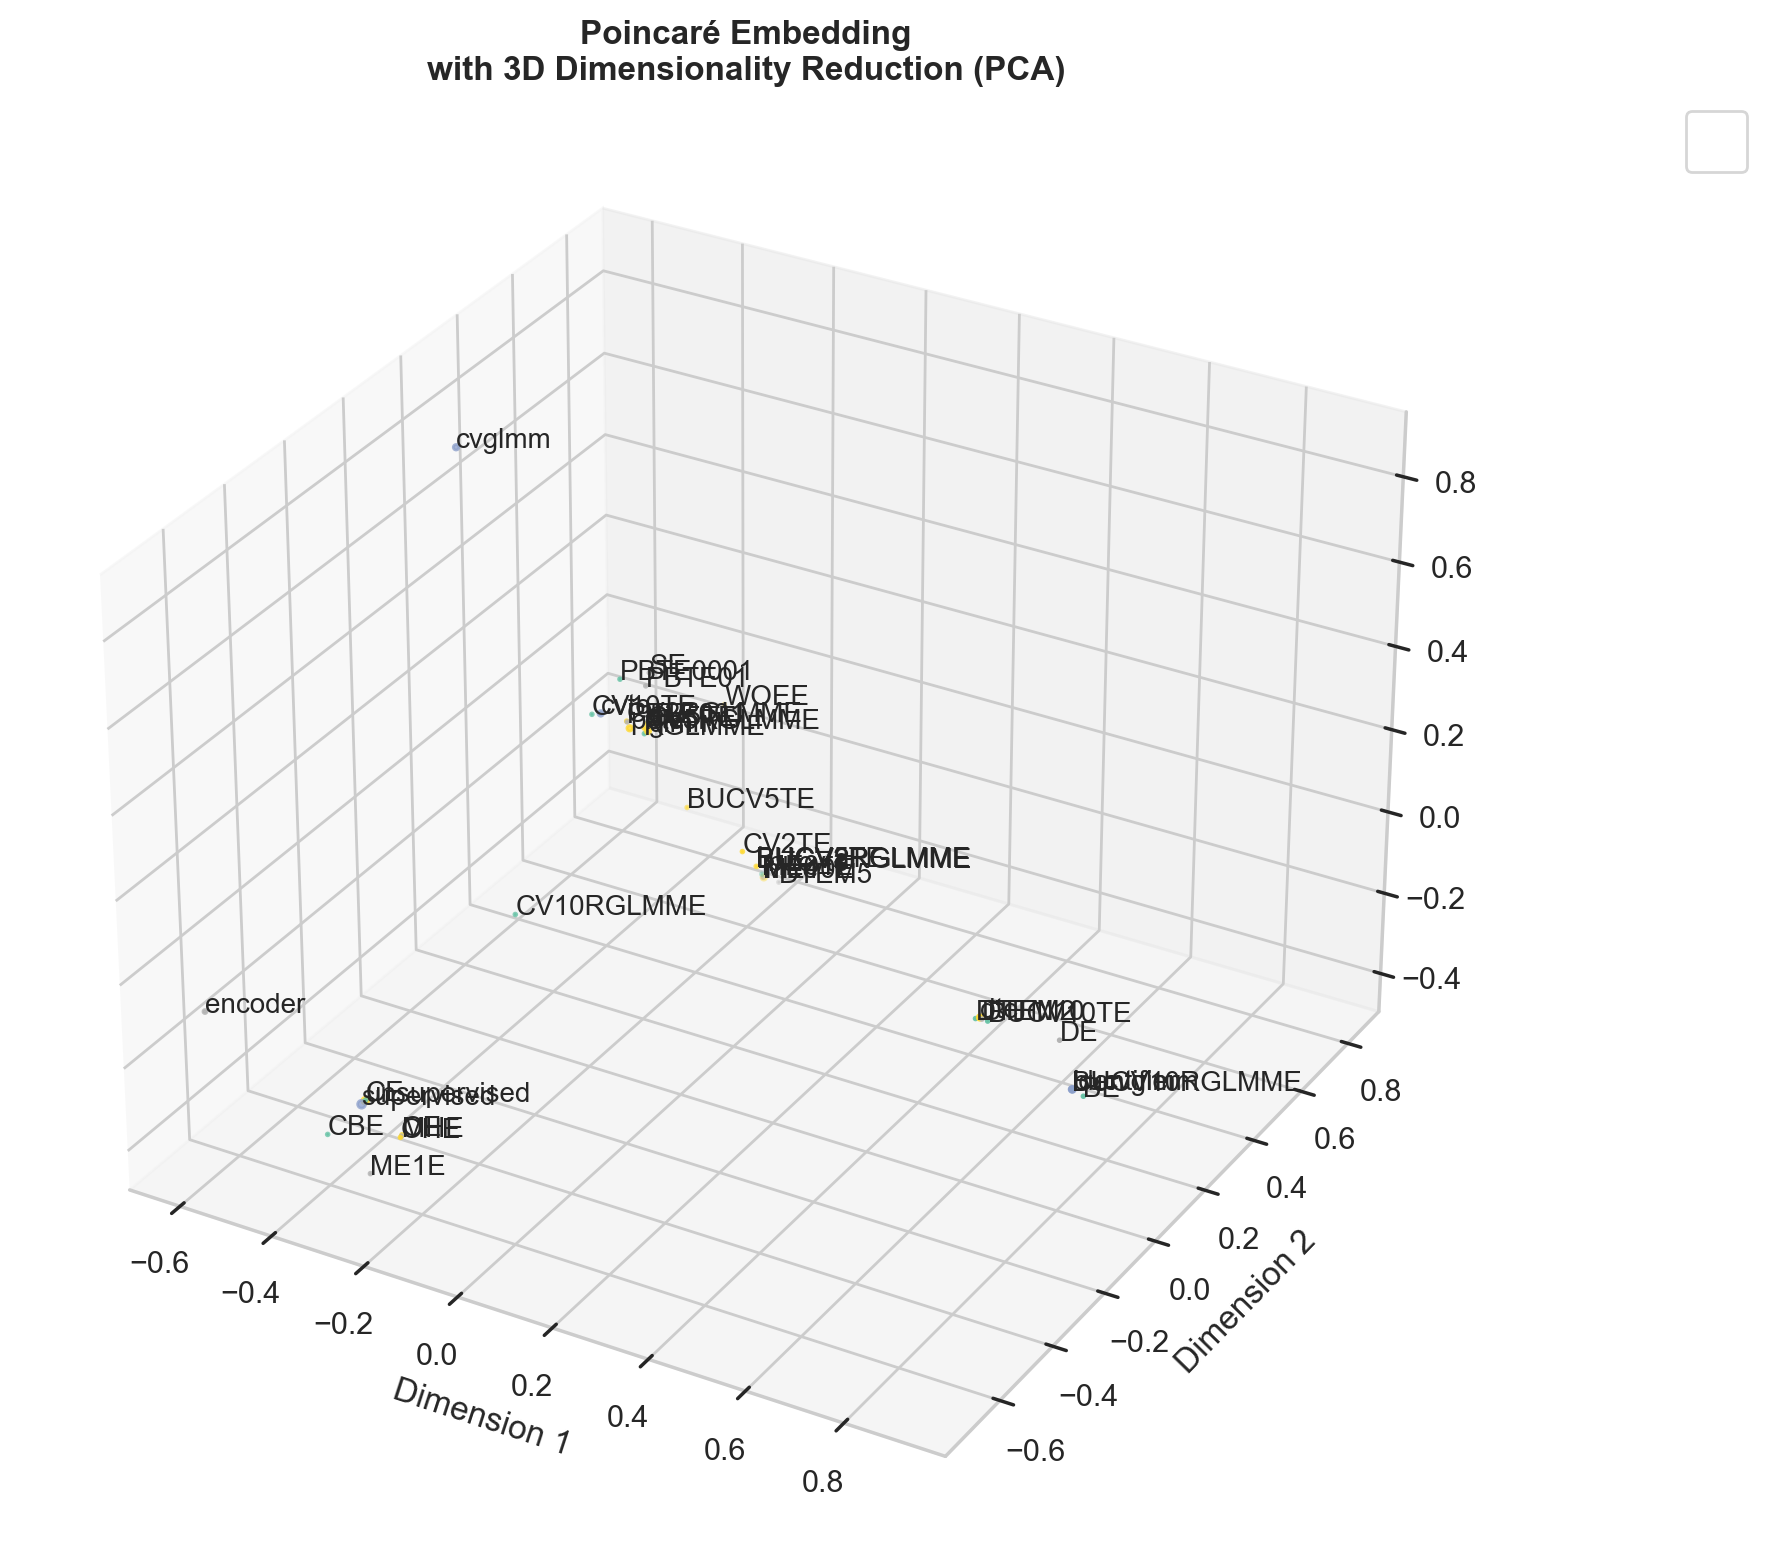

In [666]:
# Perform dimensionality reduction using PCA
pca = PCA(n_components=3, random_state=7)
embeddings_3d_pca = pca.fit_transform(embeddings_df.values)
embeddings_3d_df_pca = pd.DataFrame(embeddings_3d_pca, index=embeddings_df.index, columns=['dimension_1', 'dimension_2', 'dimension_3'])

# Add hierarchical level and degree as a column to the dataframe where node names are the index
embeddings_3d_df_pca['level'] = nx.get_node_attributes(G, 'level').values()
embeddings_3d_df_pca['degree'] = pd.Series(degree_dict)
display(embeddings_3d_df_pca)

# plot
plot_embeddigs(levels=[0, 1, 2, 3, 4], data=embeddings_3d_df_pca, subtitle='\n'+'with 3D Dimensionality Reduction (PCA)', dim=3)

## t-SNE

,dimension_1,dimension_2,dimension_3,level,degree
node,,,,,
BE,80.631950,-106.185608,-43.235741,0,1
identifier,50.536160,95.594589,40.644039,1,4
BUCV10RGLMME,101.215515,55.571873,58.233387,0,1
bucvglmm,-57.242329,-84.495682,59.471592,1,4
BUCV10TE,10.809122,79.479698,90.808105,0,1
bucvte,-81.979294,81.517670,56.887909,1,4
BUCV2RGLMME,-81.932838,-99.006416,-25.849915,2,1
BUCV2TE,144.418198,-67.065163,-4.684621,2,1
BUCV5RGLMME,-54.554180,128.027023,12.424630,2,1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


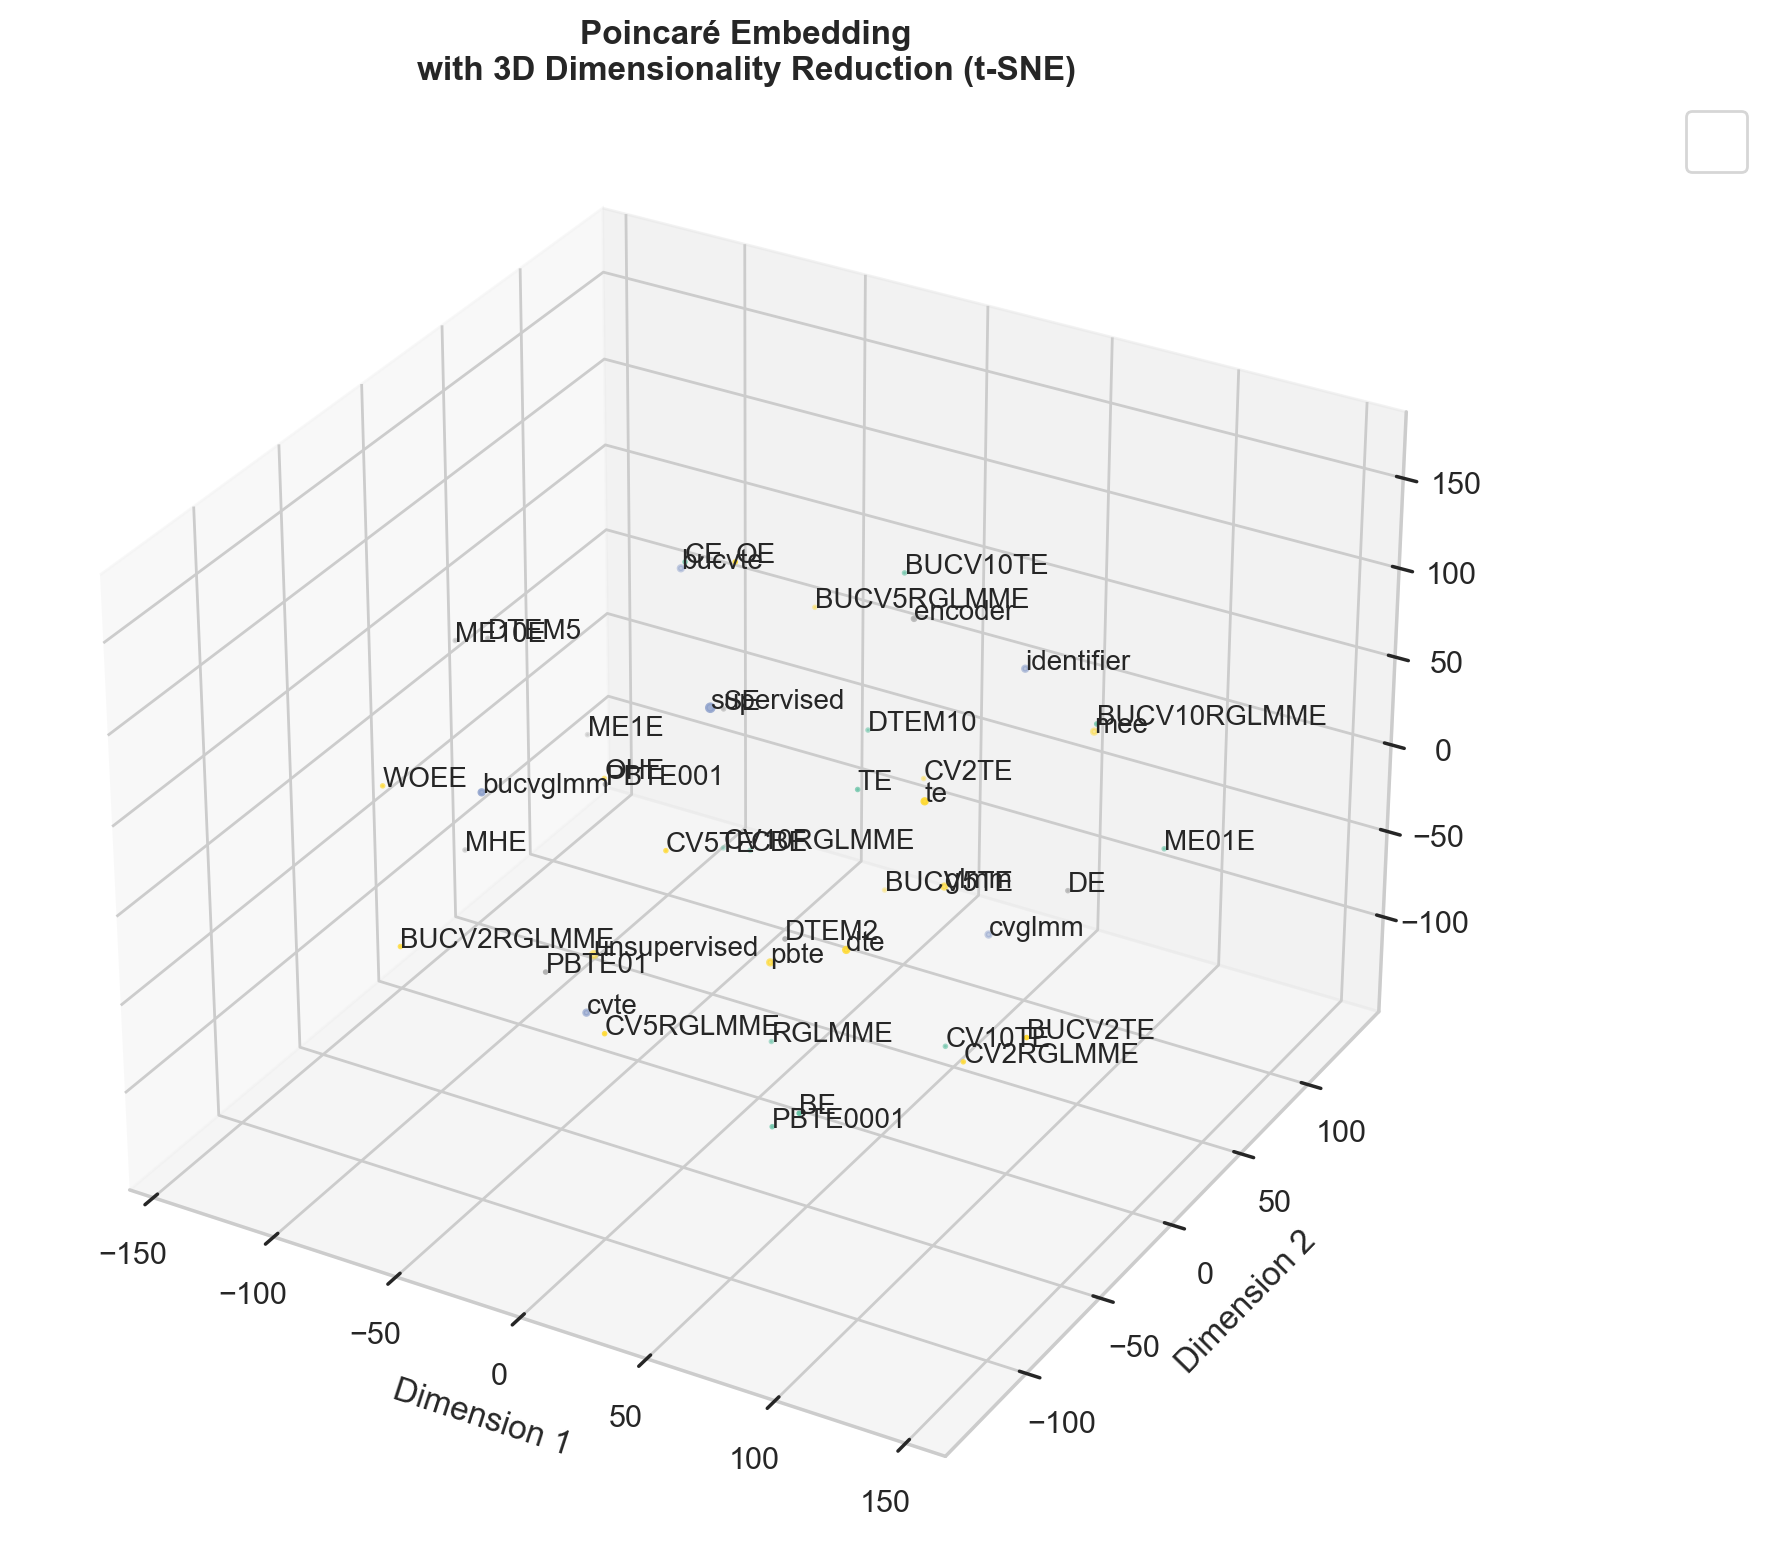

In [668]:
# Perform dimensionality reduction using t-SNE (3 dimensions)
tsne = TSNE(n_components=3, random_state=7)
embeddings_3d_tsne = tsne.fit_transform(embeddings_df.values)
embeddings_3d_df_tsne = pd.DataFrame(embeddings_3d_tsne, index=embeddings_df.index, columns=['dimension_1', 'dimension_2', 'dimension_3'])

# Add hierarchical level and degree as a column to the dataframe where node names are the index
embeddings_3d_df_tsne['level'] = nx.get_node_attributes(G, 'level').values()
embeddings_3d_df_tsne['degree'] = pd.Series(degree_dict)
display(embeddings_3d_df_tsne)

# plot
plot_embeddigs(levels=[0, 1, 2, 3, 4], data=embeddings_3d_df_tsne, subtitle='\n'+'with 3D Dimensionality Reduction (t-SNE)', dim=3)